In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
import scipy.interpolate as interp
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [15]:
def data2matrix():
    df2 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv')
    df = df2.copy()    
    #remove indexing in features 
    df = df.drop(['No'], axis=1)
    df = df.drop(['year'], axis=1)
    df = df.drop(['month'], axis = 1)
    df = df.drop(['day'], axis=1)
    #df = df.drop(['Is'], axis = 1)
    #df = df.drop(['Ir'], axis = 1)

    for i in range(1,9): 

        df['pm2.5_%d' %i] = df2['pm2.5'].shift(i)
        df['DEWP_%d' %i] = df2['DEWP'].shift(i)
        df['TEMP_%d' %i] = df2['TEMP'].shift(i)
        df['PRES_%d' %i] = df2['PRES'].shift(i)
        df['cbwd_%d' %i] = df2['cbwd'].shift(i)
        df['Iws_%d' %i] = df2['Iws'].shift(i)
        df['Is_%d' %i] = df2['Is'].shift(i)
        df['Ir_%d' %i] = df2['Ir'].shift(i)
        
    df = df[df.hour ==8] 
    #shift tomorrow's pm2.5 data into today's row
    df['pm2.5_to_predict'] = df['pm2.5'].shift(-1) 
    df = df.drop(['hour'], axis=1)
    #produce an numpy array
    df = df.dropna(how='any')
    data = np.matrix(df) 
    N = len(data)
    #Wind direction is on column 
    for i in range (N):
            for p in range(4,73,8):
                if data[i,p] == 'NE':
                    data[i,p] = 1
                elif data[i,p] == 'SE':
                    data[i,p] = 2
                elif data[i,p] == 'NW':
                    data[i,p] = 4
                elif data[i,p] == 'cv':
                    data[i,p] = 0
                    
    data = data.astype(float)
    del N, i, df2, p    
    return data

In [16]:
if __name__ == '__main__':
    data2matrix()

In [17]:
def linear_method():
    errors = []
    coefs = []
    train_e=[]
    alphas = np.logspace(-4, 4, 100)
    for a in alphas:
        #Cross validation splitter
        mse, te, coef = cross_valid\
        (X_train_scaled, y_train, Model, a, 0.5,5,10)
        #mse = float(mse[0]) 
        errors.append(mse)
        train_e.append(te)
        coefs.append(coef)
    #search for loweest error and correspondsing alpha
    mini = errors[0]
    for i in range(len(errors)):
        if errors[i] < mini:
            mini = errors[i]
            index = i        
    opt_a = alphas[index]
    print('alpha value %d has lowest error of %d' %(opt_a, mini))   
    #Plot error against alpha
    ax = plt.gca()
    ax.plot(alphas, errors, label = 'cv error')
    ax.plot(alphas, train_e, label = 'train error')
    ax.set_xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('mean squared error')
    plt.legend(loc=4)
    plt.axis('tight')
    plt.title('Ridge training and CV error versus the regularization')
    plt.show()
    
    ax = plt.gca()
    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1]) #reverse axis
    plt.xlabel('alpha')
    plt.ylabel('weights')
    plt.title('Ridge coefficients versus the regularization')
    plt.axis('tight')
    plt.show()
    train_e, test_e = testing(X_train_scaled,y_train,X_test_scaled,y_test,\
                              Model,opt_a,0.5, 0, 0)
    print('training error is %d ;testing error is %d' %(train_e,test_e))


alpha value 422 has lowest error of 6030


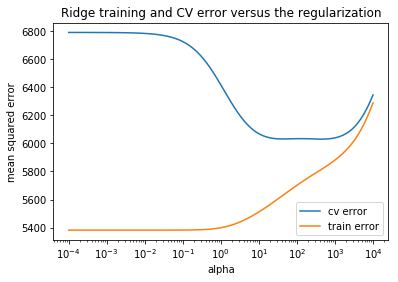

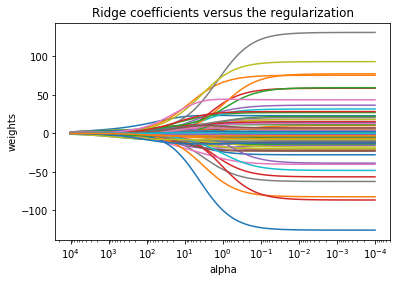

training error is 5824 ;testing error is 4597


In [ ]:
def nlinear_method():    
    C_range = np.logspace(-1, 2, 10)
    ep_range = np.logspace(-2, 1, 10)
    errors=[]
    parc=[]
    parep=[]
    i = 0
    j = 0
    e_mesh = np.zeros(shape=(len(C_range),len(ep_range)))
    t_mesh = np.zeros(shape=(len(C_range),len(ep_range)))
    for C in C_range:
        for ep in ep_range:
            #cross_valid(feature, y, name, a, l1, C, epsilon)
            mse, te, coef  = cross_valid \
            (X_train_scaled, y_train, Model, 1, 0.5, C, ep)
            e_mesh[i][j] = mse
            t_mesh[i][j] = te
            errors.append(mse)
            parc.append(C)
            parep.append(ep)
            print('hello')
            j+=1
        j=0    
        i+=1
    mini = errors[0]
    for k in range(len(errors)):
        if errors[k] < mini:
            mini = errors[k]
            index = k
    opt_c = parc[index]
    opt_ep = parep[index]
    print('C value %d, epsilon value %d has lowest error of %d' \
          %(opt_c,opt_ep, mini))
    print (opt_ep)
    # Plot the surface
    plt.imshow(e_mesh, interpolation='nearest', cmap=plt.cm.hot)
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(ep_range)), ep_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    plt.title('CV error SVM')
    plt.show()
    
    plt.imshow(t_mesh, interpolation='nearest', cmap=plt.cm.hot)
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(ep_range)), ep_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    plt.title('Train error SVM')
    plt.show()
    train_e, test_e = testing(X_train_scaled,y_train,X_test_scaled,y_test,\
                              Model,0,0.5, opt_c,opt_ep)
    print('training error is %d ;testing error is %d' %(train_e,test_e))

if __name__ == '__main__': 
    #import data from csv file to a matirx
    data = data2matrix()
    X_train, X_test, y_train, y_test = split(data)
    ind_list = [i for i in range(len(X_train))]
    shuffle(ind_list)
    X_train = X_train[ind_list]
    y_train = y_train[ind_list]
    ind_list = [i for i in range(len(X_test))]
    shuffle(ind_list)
    X_test = X_test[ind_list]
    y_test = y_test[ind_list]
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    #nomalise test set with the mean and std from training set
    X_train_scaled, X_test_scaled = normalise(X_train, X_test)
    Model = 'Ridge'
    linear_method()
    Model = 'Lasso'
    linear_method()
    Model = 'SVM'
    nlinear_method()

In [ ]:
def cross_valid(feature, y, name, a, l1, C_, ep_):
    kf = KFold(n_splits = 5)
    fold = 0
    coef = 0
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    pcv_e = 0;
    pt_e = 0;
    for train_idx, test_idx in kf.split(feature):  
        fold += 1
        X_train = feature[train_idx]
        y_train = y[train_idx]
        X_test = feature[test_idx]
        y_test = y[test_idx]
        if name == 'Ridge':
            clf = Ridge(alpha = a)
            clf.fit(X_train,y_train)
            coef = clf.coef_
        if name == 'Lasso':
            clf = Lasso(alpha = a,fit_intercept=True,tol=0.1,max_iter=50000)
            clf.fit(X_train,y_train)
            coef = clf.coef_
        if name =='elastic':
            clf = ElasticNet(alpha = a, l1_ratio = l1 ,random_state=0)
            clf.fit(X_train,y_train)
            coef = clf.coef_
        if name == 'SVM':
            clf = SVR(C=C_, gamma=ep_,epsilon=0.01, kernel='rbf',degree=3,tol=1e-2)
            clf.fit(X_train,y_train)
        y_predict1 = clf.predict(X_test)   
        y_predict2 = clf.predict(X_train) 
        t_e = mean_squared_error(y_train, y_predict2)
        t_e = t_e + pt_e
        pt_e = t_e
        cv_e = mean_squared_error(y_test, y_predict1)
        cv_e = cv_e + pcv_e
        pcv_e = cv_e

    #Then divided by number of folds getting Cross-validation error 
    cv_error = cv_e/fold
    t_error = t_e/fold

    return cv_error,t_error, coef
    
if __name__ == '__main__':
    cross_valid(feature, y, name, a, l1, C_, ep_)

In [ ]:
from sklearn import preprocessing
import numpy as np

def normalise(train, test):
    mean = np.mean(train, axis = 0)
    std = np.std(train, axis = 0)
    #std = remove_zero(std)
    test_scaled = (test - mean)/std
    train_scaled = (train - mean)/std
    return train_scaled, test_scaled

def remove_zero(array):
    N = np.shape(array)
    nu_cols = N[1]
    for i in range (0,nu_cols):
        if array[0,i]==0:
            array[0,i]=1
    return array

if __name__ == '__main__':
    normalise(train, test)
    

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

def split(data):
    #split data into training and test set
    X = data[:, 0:72]
    #PM25 to be predicted is on the last column
    y = data[:,72]
    X_train, X_test, y_train, y_test = train_test_split\
    (X, y, test_size=0.15, shuffle = False)
    return X_train, X_test, y_train, y_test

if __name__ == '__main__':
    split(data)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

def testing(X_train,y_train,X_test,y_test,name,a,l1,C_,ep_):
    if name == 'Constant':
        y_predict = round(np.mean(y_train))
        e = y_test-y_predict
        error = np.mean(np.square(e, e))
        return error
    
    if name == 'Ridge':
        #If set to false, no intercept will be used in calculations
        clf = Ridge(alpha = a)
    elif name == 'Lasso':
        #clf = Lasso(alpha = a)
        clf = Lasso(alpha = a,fit_intercept=True,tol=0.1,max_iter=50000)
    elif name =='elastic':
        clf = ElasticNet(alpha = a, l1_ratio = l1)
    elif name == 'SVM':
        clf = SVR(C=C_, gamma=ep_,epsilon=0.01, kernel='rbf',degree=1,tol=1e-2)
    clf.fit(X_train,y_train)
    y_predict = clf.predict(X_test)
    y_predict_train = clf.predict(X_train)
    #y_predict = np.ravel(y_predict)
    test_error = mean_squared_error(y_test, y_predict)
    train_error = mean_squared_error(y_train, y_predict_train)
    return train_error, test_error

    
if __name__ == '__main__':
    testing(X_train,y_train,X_test,y_test,name,a,l1,C_,ep_)